Adapted from https://medium.com/swlh/emotion-detection-using-pytorch-4f6fbfd14b2e \
Code: https://jovian.ai/conero007/emotion-detection-resnet

In [2]:
import os
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import torch.utils.data as utils_data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constants

In [4]:
data_path = '/content/drive/MyDrive/Colab Notebooks/FYP70/dataset/ck/'
model_path = '/content/drive/MyDrive/Colab Notebooks/FYP70/models/'

# Preparing the Data

### Load Numpy

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/FYP70/dataset/ck/'
with open(data_path + 'graylevels_data_no_contempt.npy', 'rb') as f:
    cropped_dataset = np.load(f)
    cropped_target = np.load(f)

### Load CSV

In [6]:
df = pd.read_csv(data_path + 'graylevels.csv')
df.head()

,filename,emotion,pixels
0,S010_004_00000019.png,anger,203 157 152 150 153 153 154 155 158 163 173 19...
1,S011_004_00000021.png,anger,182 133 134 135 131 127 131 139 142 151 162 16...
2,S014_003_00000030.png,anger,216 218 170 166 165 156 154 163 180 195 207 21...
3,S022_005_00000032.png,anger,187 143 144 151 153 154 160 173 176 177 182 18...
4,S026_003_00000015.png,anger,235 208 214 220 224 224 223 225 228 233 237 24...


In [7]:
pixels = []
for row in df.pixels:
    pixels.append([int(k) for k in row.split(' ')])
cropped_dataset = np.array(pixels)
cropped_dataset = cropped_dataset.reshape(cropped_dataset.shape[0], 1, 48, 48)
cropped_target = df.emotion

### Get DataLoaders

In [11]:
moods = ["anger","disgust","fear","happiness","sadness","surprise","neutral"]
mood_map = { moods[k]:k for k in range(len(moods)) } # mood : index
mood_map.update({ k:moods[k] for k in range(len(moods)) }) # index : mood

In [12]:
def get_dataloaders(data, label, split_ratio=0.8):
    dataset_size = data.shape[0]
    train_size = int(split_ratio * dataset_size)
    test_size = dataset_size - train_size

    dataset = utils_data.TensorDataset(torch.Tensor(data), torch.LongTensor(label))
    train_set, test_set = utils_data.random_split(dataset, [train_size, test_size])
    batch_size = 64
    train_loader = utils_data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = utils_data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
    print('Data is ready!')
    
    return train_loader, test_loader

In [13]:
Image = cropped_dataset/255.0
# Label = cropped_target
Label = np.array([float(mood_map[k]) for k in cropped_target])
print(Image.shape, Label.shape)
px_train_loader, px_test_loader = get_dataloaders(Image, Label)

(902, 1, 48, 48) (902,)
Data is ready!


# Using a GPU

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(px_train_loader, device)
valid_dl = DeviceDataLoader(px_test_loader, device)

# Training Steps Creation

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result, total, print_epoch):
        if (not epoch % print_epoch) or epoch==total-1:
            print('epoch=%d  ' % epoch + (' ' if epoch<10 else ''), end="")
            print('last_lr={:.5f}   train loss={:.4f}   test loss={:.4f}   train accuracy={:.4f}   test accuracy={:.4f}'.format(
                result['lrs'][-1], result['train_loss'], result['val_loss'], result['train_acc'], result['val_acc']))

# Model Creation

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

# Training the Model

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(model, train_loader, val_loader,
                  epochs, max_lr,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD,
                  best_acc=0, print_epoch=1):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    best_state = model.state_dict()
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses, train_accs = [], []
        lrs = []
        for batch in train_loader:            
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result, total=epochs, print_epoch=print_epoch)
        history.append(result)  

        # Save model
        if result['val_acc'] > best_acc:
            best_state = model.state_dict()
            best_acc = result['val_acc']
        
    return history, best_state

In [24]:
# Create new model
model = to_device(ResNet(1, len(moods)), device)
history = [evaluate(model, valid_dl)]
print(history)

In [21]:
# Load new model
state = torch.load(model_path + 'CNN_fer.pth', map_location='cpu')
model.load_state_dict(state['state_dict'])
history = state['history']

In [22]:
# model_path = '/content/drive/MyDrive/Colab Notebooks/FYP70/models/CNN_fer_ckpt.pth'
# model.load_state_dict(torch.load(model_path, map_location='cpu'))

In [25]:
%%time
history_one_cycle, best_state = fit_one_cycle(model, train_dl, valid_dl, 
                                              epochs=100, max_lr=0.008, 
                                              grad_clip=0.1, weight_decay=1e-4, opt_func=torch.optim.Adam,
                                              best_acc=max([x['val_acc'] for x in history]), print_epoch=1)
history = ([] if len(history)==1 else history) + history_one_cycle

epoch=0   last_lr=0.00034   train loss=1.7516   test loss=4.1225   train accuracy=0.5516   test accuracy=0.0156
epoch=1   last_lr=0.00040   train loss=0.8316   test loss=1.0735   train accuracy=0.7522   test accuracy=0.7945
epoch=2   last_lr=0.00050   train loss=0.7161   test loss=0.8302   train accuracy=0.7913   test accuracy=0.7882
epoch=3   last_lr=0.00064   train loss=0.5567   test loss=0.5539   train accuracy=0.8392   test accuracy=0.8477
epoch=4   last_lr=0.00082   train loss=0.4950   test loss=0.4549   train accuracy=0.8330   test accuracy=0.8728
epoch=5   last_lr=0.00104   train loss=0.4261   test loss=0.5712   train accuracy=0.8623   test accuracy=0.8613
epoch=6   last_lr=0.00129   train loss=0.3829   test loss=1.0795   train accuracy=0.8912   test accuracy=0.5804
epoch=7   last_lr=0.00157   train loss=0.3795   test loss=0.4492   train accuracy=0.8860   test accuracy=0.8833
epoch=8   last_lr=0.00188   train loss=0.3780   test loss=0.4605   train accuracy=0.8860   test accuracy

# Plotting Performance Graphs of the Model

In [26]:
def plot_accuracies(history):
  train_accs = [x['train_acc'] for x in history]
  val_accs = [x['val_acc'] for x in history]
  plt.plot(train_accs, label='Train accuracy')
  plt.plot(val_accs, label='Val accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.title('Accuracy vs. No. of epochs');

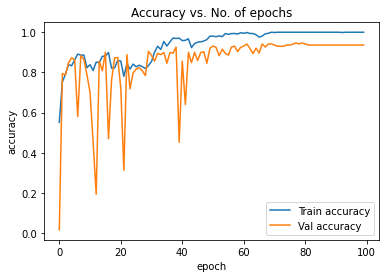

In [27]:
plot_accuracies(history)

In [28]:
def plot_losses(history):
  train_losses = [x['train_loss'] for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, label='Train loss')
  plt.plot(val_losses, label='Val loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.title('Loss vs. No. of epochs');

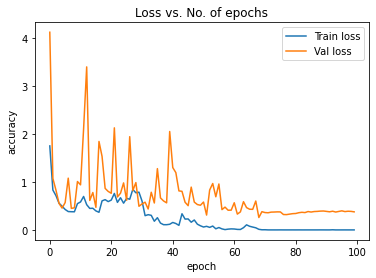

In [29]:
plot_losses(history)

## Saving the Model


In [31]:
# torch.save(model.state_dict(), './trained_models/CNNModel.pth')
state = {
    'history': history,
    'state_dict': best_state
}
torch.save(state, model_path + 'CNN_ck.pt')

# Testing the Model

In [32]:
import random
import math
import dlib
import cv2
import imutils
from imutils import face_utils

In [33]:
# load models
test_model = to_device(ResNet(1, len(moods)), device)
test_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/FYP70/models/CNN_ck.pt')['state_dict'])
test_model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

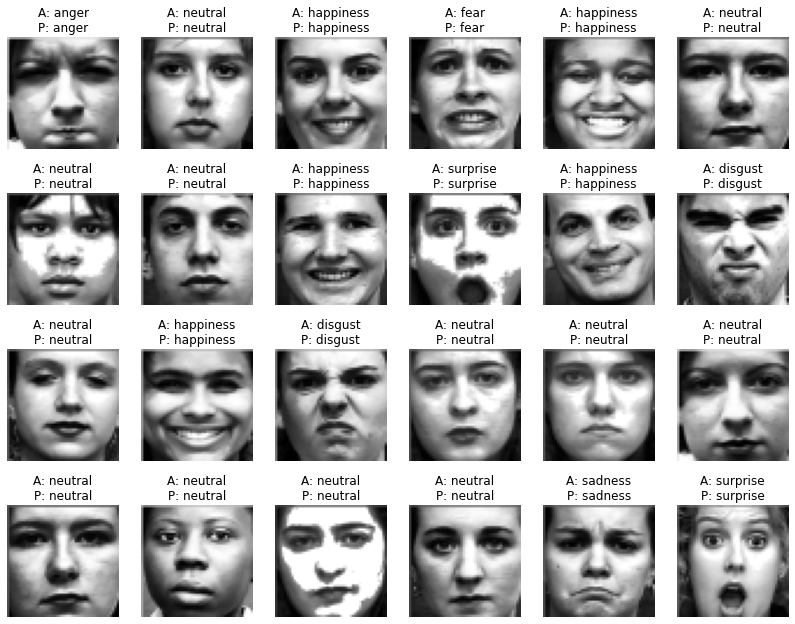

In [38]:
rand = random.sample(range(cropped_target.size), 24)
fig = plt.figure(figsize=(14, 11))

for i in rand:
    img = cropped_dataset[i]
    cnn_input = img.reshape(1,1,48,48)/255.0 # shape=(1,1,dim,dim)

    # prediction
    with torch.no_grad():
        pred_tensor = test_model(torch.Tensor(cnn_input).cuda())
        pred = pred_tensor.argmax().cpu().numpy().item()        
    pred_label = mood_map[pred]
    # true_label = mood_map[cropped_target[i]]
    true_label = cropped_target[i]

    fig.add_subplot(4, 6, rand.index(i)+1)
    plt.title("A: %s\nP: %s" % (true_label, pred_label))
    plt.axis("off")
    plt.imshow(img[0], cmap="gray")

plt.show()